<a href="https://colab.research.google.com/github/arulmickel/DermAI-ISIC2018-Skin-Lesion-Classifier/blob/main/final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
 extracting: images/ISIC2018_Task3_Training_Input/ISIC_0029322.jpg  
  inflating: images/ISIC2018_Task3_Training_Input/ISIC_0029323.jpg  
 extracting: images/ISIC2018_Task3_Training_Input/ISIC_0029324.jpg  
 extracting: images/ISIC2018_Task3_Training_Input/ISIC_0029325.jpg  
 extracting: images/ISIC2018_Task3_Training_Input/ISIC_0029326.jpg  
 extracting: images/ISIC2018_Task3_Training_Input/ISIC_0029327.jpg  
 extracting: images/ISIC2018_Task3_Training_Input/ISIC_0029328.jpg  
 extracting: images/ISIC2018_Task3_Training_Input/ISIC_0029329.jpg  
 extracting: images/ISIC2018_Task3_Training_Input/ISIC_0029330.jpg  
  inflating: images/ISIC2018_Task3_Training_Input/ISIC_0029331.jpg  
  inflating: images/ISIC2018_Task3_Training_Input/ISIC_0029332.jpg  
 extracting: images/ISIC2018_Task3_Training_Input/ISIC_0029333.jpg  
 extracting: images/ISIC2018_Task3_Training_Input/ISIC_0029334.jpg  
  inflating: images/ISIC2018_Task3_Training_Input/IS

Saving labels.csv to labels.csv
Final image count after removing missing: 10015


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 30.1MB/s]


Epoch 1, Loss: 0.6569
Epoch 2, Loss: 0.2984
Epoch 3, Loss: 0.1248

Classification Report:

              precision    recall  f1-score   support

         MEL       0.66      0.50      0.57       239
          NV       0.92      0.91      0.91      1338
         BCC       0.70      0.73      0.71       106
       AKIEC       0.81      0.40      0.54        62
         BKL       0.53      0.83      0.65       206
          DF       0.76      0.59      0.67        22
        VASC       0.93      0.87      0.90        30

    accuracy                           0.82      2003
   macro avg       0.76      0.69      0.71      2003
weighted avg       0.83      0.82      0.82      2003



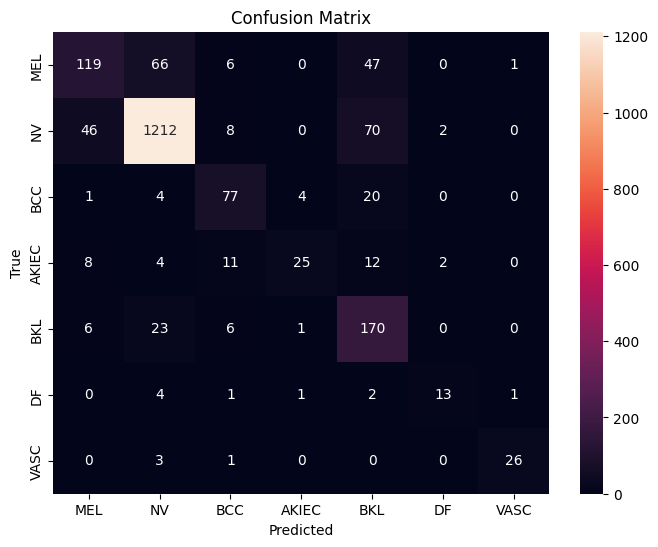

In [ ]:
# 📦 Step 0: Install required packages
!pip install torch torchvision scikit-learn seaborn

# 📥 Step 1: Download and unzip the ISIC 2018 dataset
!rm -rf images/ ISIC2018_Task3_Training_Input.zip  # Clean up if rerunning
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
!unzip -o ISIC2018_Task3_Training_Input.zip -d images

# 📄 Step 2: Upload CSV manually
from google.colab import files
uploaded = files.upload()  # Upload ISIC2018_Task3_Training_GroundTruth.csv (even if renamed to (1))

# 📁 Step 3: Fix CSV name if uploaded with (1)
import os
for f in uploaded.keys():
    if "GroundTruth" in f:
        os.rename(f, "labels.csv")

# 📚 Step 4: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 📍 Step 5: Paths & labels
images_path = "images/ISIC2018_Task3_Training_Input"
labels_path = "labels.csv"
df = pd.read_csv(labels_path)
label_map = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# 🛡️ Step 6: Remove entries with missing image files
df = df[df['image'].apply(lambda x: os.path.exists(os.path.join(images_path, x + '.jpg')))].reset_index(drop=True)
print(f"Final image count after removing missing: {len(df)}")

# 🧱 Step 7: Custom Dataset
class ISICDataset(Dataset):
    def __init__(self, dataframe, images_path, label_map, transform=None):
        self.df = dataframe
        self.images_path = images_path
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['image']
        label_index = row[self.label_map].values.argmax()
        img_path = os.path.join(self.images_path, image_id + '.jpg')
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label_index

# 🔧 Step 8: Transforms and Dataloaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = ISICDataset(train_df, images_path, label_map, transform=transform)
val_dataset = ISICDataset(val_df, images_path, label_map, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 🤖 Step 9: Load model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 7)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 🎯 Step 10: Train the model
for epoch in range(3):  # Keep it short for testing
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

# 📊 Step 11: Evaluate the model
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_map))

# 📉 Step 12: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map, yticklabels=label_map)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
